In [1]:
import sys
sys.path.append("..")

In [2]:
# %pip install UMAP
# %pip install umap
# %pip install --upgrade umap-learn
# %pip install -U kaleido

In [3]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances, cosine_distances
import numpy as np
import logging
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import plotly.express as px
import matplotlib.colors as mcolors
import warnings
import io
from PIL import Image
import nbformat
import IPython
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
from dch_etl.azure_clients.openai_client import OpenAiClient
import plotly.io as pio
from sklearn.metrics import pairwise
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import MinCovDet
from sklearn.neighbors import NearestNeighbors
from collections import Counter

import nbconvert
import networkx as nx
#from azure.core.credentials import AzureKeyCredential
#from azure.search.documents import SearchClient

## Importar y crear df

In [4]:
import csv

file_path = 'C:\\Users\\55641856\\Desktop\\prep-script\\cluster_centroids.csv'
with open(file_path, "r") as file:
    reader = csv.DictReader(file)
    keys = reader.fieldnames
    results = list(reader)

In [5]:
centroides_df = pd.read_csv(file_path)

# Check if the specified columns exist before selecting them
columns = ['cluster_label', 'centroid', 'etiqueta']
missing_columns = [col for col in columns if col not in centroides_df.columns]

if missing_columns:
    print(f"Warning: The following columns are missing: {missing_columns}")
else:
    centroides_df = centroides_df[columns]


In [6]:
import json

file_path = 'C:\\Users\\55641856\\Desktop\\prep-script\\documentos_pre.json'
with open(file_path, "r") as file:
    results2 = json.load(file)

In [7]:
results2[0].keys()

dict_keys(['document_path', 'ts_file_update', 'category', 'description', 'original_canonic_path', 'content_vector', 'dt_end', 'document_id', 'file_size', 'calendar_name', 'location', 'site_name', 'sp', 'title', 'sheet_name', 'event_id', 'event_name', 'dt_start', 'content', 'etiqueta_cluster', 'event_url', 'ts_creation', 'original_path', 'content_md', 'document_name', 'chunk_id', 'content_type', 'id', 'ts_processed', 'page_number', '@search.score', '@search.reranker_score', '@search.highlights', '@search.captions'])

In [ ]:
embeddings_df = pd.DataFrame(results2)[['original_path', "id", "content", "content_type","category", "content_vector", 'document_id', 'chunk_id', 'page_number', 'event_url', 'document_name', 'title', 'description']]

Normalizar los vectores en content_vector

In [9]:
# Función para normalizar un vector
def normalizar_vector(vector):
    norma = np.linalg.norm(vector)
    return vector / norma if norma != 0 else vector

# Aplicar la normalización a cada vector en la columna content_vector
embeddings_df['content_vector_norm'] = embeddings_df['content_vector'].apply(normalizar_vector)

Asignar etiqueta a cada embedding normalizado

In [10]:
# Convertir centroides a un array de numpy, asegurando que son numéricos
centroides = np.array([np.fromstring(c[1:-1], sep=',') for c in centroides_df['centroid'].values])

# # Verifica las dimensiones
# print("Dimensiones de los embeddings:", embeddings_df['content_vector_norm'].iloc[0].shape)
# print("Dimensiones de los centroides:", centroides.shape)

# Función para calcular la distancia Euclidiana
def calcular_distancia(embedding, centroides):
    return np.linalg.norm(centroides - embedding, axis=1)

# Listas para almacenar las etiquetas y los centroides más cercanos
etiquetas_cercanas = []
centroides_cercanos = []

# Iterar sobre cada embedding en embeddings_df
for index, row in embeddings_df.iterrows():
    embedding = row['content_vector_norm']
    distancias = calcular_distancia(embedding, centroides)
    indice_minimo = np.argmin(distancias)
    
    # Agregar la etiqueta y el centroide correspondiente al DataFrame
    etiquetas_cercanas.append(centroides_df['etiqueta'].iloc[indice_minimo])
    centroides_cercanos.append(centroides[indice_minimo])

# Crear nuevas columnas en embeddings_df
embeddings_df['etiqueta_asignada'] = etiquetas_cercanas
embeddings_df['centroide'] = centroides_cercanos



In [16]:
# Contar el número total de 'document_id' y 'chunk_id'
num_document_ids = embeddings_df['document_id'].nunique()
num_chunk_ids = embeddings_df['chunk_id'].count()

print(f"Total de 'document_id': {num_document_ids}")
print(f"Total de 'chunk_id': {num_chunk_ids}")


Total de 'document_id': 1190
Total de 'chunk_id': 5755


Asignamos un color a cada tipo de chunk

In [17]:
color_mapping = {
    'site': '#FFB347',
    'calendar': '#84b6f4',  
    'table': '#77dd77',    
    'document': '#ff6961',      
}
embeddings_df['color'] = embeddings_df['category'].map(color_mapping)

Asignamos un número a cada etiqueta

In [18]:
# Paso 1: Crear un diccionario para asignar números a cada etiqueta
etiquetas_unicas = embeddings_df['etiqueta_asignada'].unique()
etiqueta_dict = {etiqueta: i for i, etiqueta in enumerate(etiquetas_unicas)}

# Paso 2: Crear una nueva columna en el DataFrame
embeddings_df['etiqueta_numero'] = embeddings_df['etiqueta_asignada'].map(etiqueta_dict)

Missing silhouette plot

In [19]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score

# # Assuming embeddings_df is already defined and contains 'content_vector_norm'
# X = np.vstack(embeddings_df['content_vector_norm'].to_numpy())

# # Perform 100 calculations per cluster and take the best silhouette score for each cluster count
# range_n_clusters = range(30, 60)
# best_silhouette_scores = []
# best_random_seeds = []  # Store the random seed for the best score

# for n_clusters in range_n_clusters:
#     best_score = -1  # Initialize with the lowest possible score
#     best_seed = None  # To store the best random seed
#     for seed in range(5):  # Perform 100 iterations with different random seeds
#         kmeans = KMeans(n_clusters=n_clusters, random_state=seed)  # Random seed each time
#         cluster_labels = kmeans.fit_predict(X)
#         silhouette_avg = silhouette_score(X, cluster_labels)
        
#         if silhouette_avg > best_score:
#             best_score = silhouette_avg  # Update the best score for this cluster count
#             best_seed = seed  # Store the best seed for the optimal silhouette score
    
#     best_silhouette_scores.append(best_score)
#     best_random_seeds.append(best_seed)  # Append the best seed for the cluster count

# # Plot the best silhouette scores
# plt.figure(figsize=(10, 6))
# plt.plot(range_n_clusters, best_silhouette_scores, marker='o', linestyle='-', color='b')
# plt.title("Best Silhouette Scores for Various Numbers of Clusters")
# plt.xlabel("Number of Clusters")
# plt.ylabel("Best Silhouette Score")
# plt.xticks(range_n_clusters)
# plt.grid(True)
# plt.show()

# # If you want to see the random seeds that resulted in the best scores for each cluster count:
# print("Best random seeds for each cluster count:")
# for n_clusters, seed in zip(range_n_clusters, best_random_seeds):
#     print(f"Cluster count {n_clusters}: Best random seed {seed}")


Chunks similarity

In [20]:
def similarity(embeddings_df):
    data = embeddings_df[['document_id', 'chunk_id', 'content_vector_norm']]

    # Compute similarity within each document
    similarity_results = []
    for document_id, group in data.groupby('document_id'):
        chunk_vectors = np.vstack(group['content_vector_norm'].to_numpy())
        n_chunks = chunk_vectors.shape[0]
        
        # Handle documents with only one chunk
        if n_chunks == 1:
            similarity_results.append({'document_id': document_id, 'n_chunks': 1, 
                                    'similarity_above_0.8': 0, 'similarity_below_0.8': 0})
            continue

        # Compute pairwise cosine similarity
        similarity_matrix = cosine_similarity(chunk_vectors)
        upper_tri_indices = np.triu_indices(n_chunks, k=1)
        pairwise_similarities = similarity_matrix[upper_tri_indices]
        
        # Categorize similarities
        above_0_8 = np.sum(pairwise_similarities > 0.8)
        below_0_8 = np.sum(pairwise_similarities <= 0.8)

        similarity_results.append({
            'document_id': document_id,
            'n_chunks': n_chunks,
            'similarity_above_0.8': above_0_8,
            'similarity_below_0.8': below_0_8
        })

    # Create a DataFrame of the results
    similarity_df = pd.DataFrame(similarity_results)

    # Compute overall statistics
    total_documents = similarity_df.shape[0]
    one_chunk_documents = similarity_df[similarity_df['n_chunks'] == 1].shape[0]
    multi_chunk_documents = total_documents - one_chunk_documents

    total_comparisons = similarity_df['similarity_above_0.8'].sum() + similarity_df['similarity_below_0.8'].sum()
    percent_above_0_8 = similarity_df['similarity_above_0.8'].sum() / total_comparisons * 100
    percent_below_0_8 = similarity_df['similarity_below_0.8'].sum() / total_comparisons * 100
    percent_one_chunk = one_chunk_documents / total_documents * 100

    # Bar plot visualization
    labels = ['>0.8 Similarity', '<=0.8 Similarity', 'One Chunk Documents']
    percentages = [percent_above_0_8, percent_below_0_8, percent_one_chunk]

    plt.figure(figsize=(10, 6))
    plt.bar(labels, percentages, color=['green', 'orange', 'blue'])
    plt.title('Cosine Similarity Distribution for Chunks belonging to same Document')
    plt.ylabel('Percentage (%)')
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for i, percentage in enumerate(percentages):
        plt.text(i, percentage + 1, f"{percentage:.2f}%", ha='center', fontsize=12)
    plt.show()

    # Print summary
    print(f"Total Documents: {total_documents}")
    print(f"Documents with One Chunk: {one_chunk_documents} ({percent_one_chunk:.2f}%)")
    print(f"Total Pairwise Comparisons: {total_comparisons}")
    print(f"Percentage > 0.8 Similarity: {percent_above_0_8:.2f}%")
    print(f"Percentage <= 0.8 Similarity: {percent_below_0_8:.2f}%")


In [45]:
def similarity(embeddings_df):
    data = embeddings_df[['document_id', 'chunk_id', 'content_vector_norm']]

    similarity_results = []
    for document_id, group in data.groupby('document_id'):
        chunk_vectors = np.vstack(group['content_vector_norm'].to_numpy())
        n_chunks = chunk_vectors.shape[0]
        
        if n_chunks == 1:
            similarity_results.append({'document_id': document_id, 'n_chunks': 1, 
                                    'similarity_above_0.8': 0, 'similarity_below_0.8': 0})
            continue

        similarity_matrix = cosine_similarity(chunk_vectors)
        upper_tri_indices = np.triu_indices(n_chunks, k=1)
        pairwise_similarities = similarity_matrix[upper_tri_indices]
        
        above_0_8 = np.sum(pairwise_similarities > 0.8)
        below_0_8 = np.sum(pairwise_similarities <= 0.8)

        similarity_results.append({
            'document_id': document_id,
            'n_chunks': n_chunks,
            'similarity_above_0.8': above_0_8,
            'similarity_below_0.8': below_0_8
        })

    similarity_df = pd.DataFrame(similarity_results)

    total_documents = similarity_df.shape[0]
    one_chunk_documents = similarity_df[similarity_df['n_chunks'] == 1].shape[0]
    multi_chunk_documents = total_documents - one_chunk_documents

    total_comparisons = similarity_df['similarity_above_0.8'].sum() + similarity_df['similarity_below_0.8'].sum()
    percent_above_0_8 = similarity_df['similarity_above_0.8'].sum() / total_comparisons * 100
    percent_below_0_8 = similarity_df['similarity_below_0.8'].sum() / total_comparisons * 100
    percent_one_chunk = one_chunk_documents / total_documents * 100
    percent_multi_chunk = multi_chunk_documents / total_documents * 100

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    colors7 = sns.color_palette('cubehelix', 8)[6]  # Color 7
    colors8 = sns.color_palette('cubehelix', 8)[7]  # Color 8
    colors9 = sns.cubehelix_palette(8)[0]
    colors10 = sns.cubehelix_palette(8)[1]

    # First subplot: Document chunk distribution with hatching
    chunk_labels = ['One Chunk', 'Multiple Chunks']
    chunk_percentages = [percent_one_chunk, percent_multi_chunk]
    bars1 = ax1.bar(chunk_labels, chunk_percentages, color=[colors7,colors8], alpha=0.8)
    hatches1 = ['.', ' ']  # Hatching patterns for first plot
    for bar, hatch in zip(bars1, hatches1):
        bar.set_hatch(hatch)
    ax1.set_title('Document Chunk Distribution')
    ax1.set_ylabel('Percentage (%)')
    ax1.set_ylim(0, 100)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    for i, percentage in enumerate(chunk_percentages):
        ax1.text(i, percentage + 1, f"{percentage:.2f}%", ha='center', fontsize=10)

    # Second subplot: Similarity distribution with hatching
    similarity_labels = ['>0.8 Similarity', '≤0.8 Similarity']
    similarity_percentages = [percent_above_0_8, percent_below_0_8]
    bars2 = ax2.bar(similarity_labels, similarity_percentages,color=[colors9,colors10], alpha=0.8)
    hatches2 = ['/', ' ']  # Hatching patterns for second plot
    for bar, hatch in zip(bars2, hatches2):
        bar.set_hatch(hatch)
    ax2.set_title('Chunk Similarity Distribution')
    ax2.set_ylabel('Percentage (%)')
    ax2.set_ylim(0, 100)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    for i, percentage in enumerate(similarity_percentages):
        ax2.text(i, percentage + 1, f"{percentage:.2f}%", ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"Total Documents: {total_documents}")
    print(f"Documents with One Chunk: {one_chunk_documents} ({percent_one_chunk:.2f}%)")
    print(f"Total Pairwise Comparisons: {total_comparisons}")
    print(f"Percentage > 0.8 Similarity: {percent_above_0_8:.2f}%")
    print(f"Percentage <= 0.8 Similarity: {percent_below_0_8:.2f}%")


C:\Users\55641856\AppData\Local\Temp\ipykernel_19312\2914894406.py:53: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  bar.set_hatch(hatch)
C:\Users\55641856\AppData\Local\Temp\ipykernel_19312\2914894406.py:67: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  bar.set_hatch(hatch)


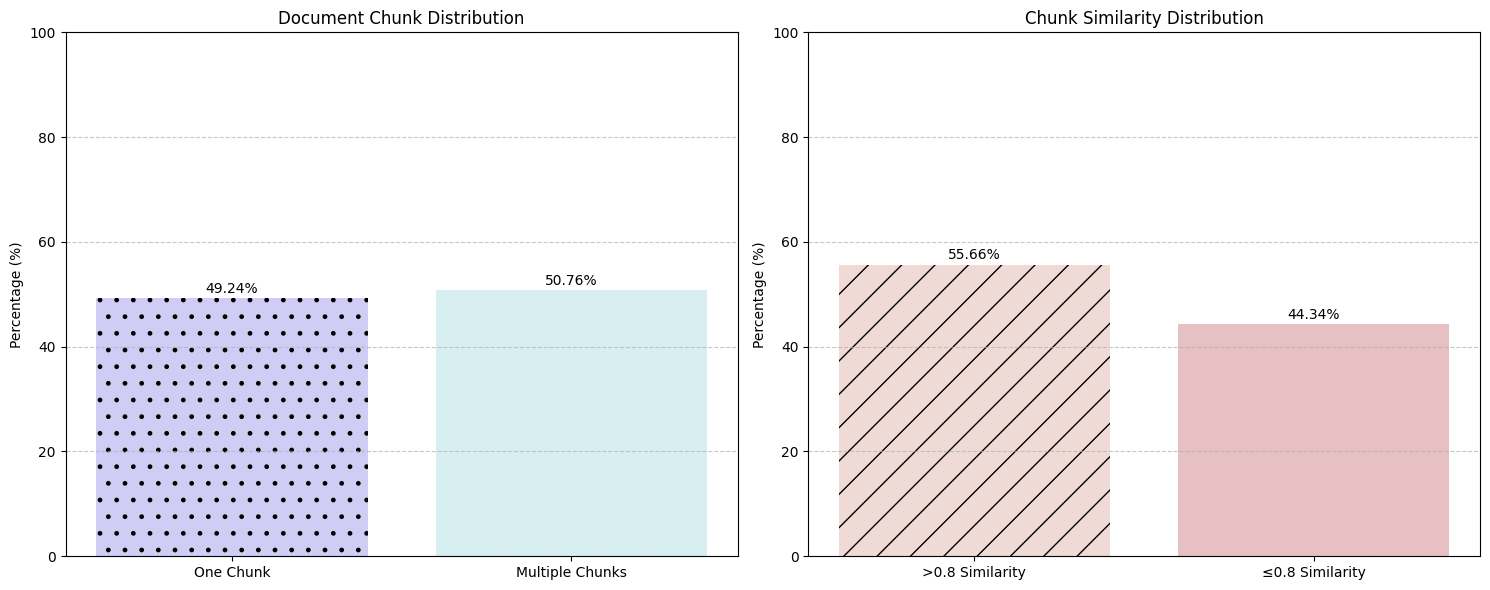

Total Documents: 1190
Documents with One Chunk: 586 (49.24%)
Total Pairwise Comparisons: 346486
Percentage > 0.8 Similarity: 55.66%
Percentage <= 0.8 Similarity: 44.34%


In [46]:
similarity(embeddings_df)